In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd '/content/drive/MyDrive/Deep_learning'

/content/drive/MyDrive/Deep_learning


In [3]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import torchvision
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from pytorchcv import train, plot_results

In [13]:
class Inception(nn.Module):
    # 'c1'--'c4' are the number of output channels for each branch
    def __init__(self, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # Branch 1
        self.b1 = nn.Sequential(
            nn.LazyConv2d(c1, kernel_size = 1),
            nn.LazyBatchNorm2d(), nn.ReLU()
        )
        # Branch 2
        self.b2 = nn.Sequential(
            nn.LazyConv2d(c2[0], kernel_size = 1),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.LazyConv2d(c2[1], kernel_size = 3, padding = 1),
            nn.LazyBatchNorm2d(), nn.ReLU()
        )
        # Branch 3
        self.b3 = nn.Sequential(
            nn.LazyConv2d(c3[0], kernel_size = 1),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.LazyConv2d(c3[1], kernel_size = 5, padding = 2),
            nn.LazyBatchNorm2d(), nn.ReLU()
        )
        # Branch 4
        self.b4 = nn.Sequential(
            nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 1),
            nn.LazyConv2d(c4, kernel_size = 1),
            nn.LazyBatchNorm2d(), nn.ReLU()
        )

    def forward(self, x):
        b1 = self.b1(x)
        b2 = self.b2(x)
        b3 = self.b3(x)
        b4 = self.b4(x)
        return torch.cat((b1, b2, b3, b4), dim = 1)

In [14]:
class GoogLeNet(nn.Module):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size = 7, stride = 2, padding = 3),
            nn.LazyBatchNorm2d(),
            nn.ReLU(), nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        )
    
    def b2(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size = 1), nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.LazyConv2d(192, kernel_size = 3, padding = 1), nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        )

    def b3(self):
        return nn.Sequential(
            Inception(64, (96, 128), (16, 32), 32),
            Inception(128, (128, 192), (32, 96), 64),
            nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1))
        
    def b4(self):
        return nn.Sequential(
            Inception(192, (96, 208), (16, 48), 64),
            Inception(160, (112, 224), (24, 64), 64),
            Inception(128, (128, 256), (24, 64), 64),
            Inception(112, (144, 288), (32, 64), 64),
            Inception(256, (160, 320), (32, 128), 128),
            nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        )
    
    def b5(self):
        return nn.Sequential(
            Inception(256, (160, 320), (32, 128), 128),
            Inception(384, (192, 384), (48, 128), 128),
            nn.AdaptiveAvgPool2d((1,1)), nn.Flatten()
        )
    
    def __init__(self, lr = 0.1, num_classes = 10):
        super(GoogLeNet, self).__init__()
        self.lr = lr
        self.num_classes = num_classes
        self.net = nn.Sequential(self.b1(), self.b2(), self.b3(), self.b4(), self.b5(), nn.LazyLinear(num_classes))

    def forward(self, X):
        return self.net(X)

    def layer_summary(self, input_size):
        X = torch.randn(*input_size)
        for layer in self.net:
            X = layer(X)
            print(layer.__class__.__name__, 'output shape:\t', X.shape)

    def apply_init(self, inputs, init = None):
        self.forward(*inputs)
        if init is not None:
            self.net.apply(init)

def init_cnn(module):
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

In [15]:
trans = transforms.Compose([transforms.ToTensor(), transforms.Resize(96)])
data_train = datasets.FashionMNIST(
    root = './data',
    train = True,
    download = False,
    transform = trans
)

data_val = datasets.FashionMNIST(
    root = './data',
    train = False,
    download = False,
    transform = trans
)

In [16]:
train_loader = torch.utils.data.DataLoader(data_train, batch_size = 128, shuffle = True, pin_memory = True)
val_loader = torch.utils.data.DataLoader(data_val, batch_size = 128, pin_memory = True)

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [18]:
net = GoogLeNet()
net.apply_init([next(iter(train_loader))[0]], init_cnn)

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [19]:
!pip install torchinfo
from torchinfo import summary
summary(net, input_size = [1,1,96,96])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Layer (type:depth-idx)                        Output Shape              Param #
GoogLeNet                                     [1, 10]                   --
├─Sequential: 1-1                             [1, 10]                   --
│    └─Sequential: 2-1                        [1, 64, 24, 24]           --
│    │    └─Conv2d: 3-1                       [1, 64, 48, 48]           3,200
│    │    └─BatchNorm2d: 3-2                  [1, 64, 48, 48]           128
│    │    └─ReLU: 3-3                         [1, 64, 48, 48]           --
│    │    └─MaxPool2d: 3-4                    [1, 64, 24, 24]           --
│    └─Sequential: 2-2                        [1, 192, 12, 12]          --
│    │    └─Conv2d: 3-5                       [1, 64, 24, 24]           4,160
│    │    └─BatchNorm2d: 3-6                  [1, 64, 24, 24]           128
│    │    └─ReLU: 3-7                         [1, 64, 24, 24]           --
│    │    └─Conv2d: 3-8                       [1, 192, 24, 24]          110,784
│    │ 

In [20]:
optimizer = torch.optim.SGD(net.parameters(), lr = net.lr, momentum = 0.9, nesterov = True)
hist = train(net, train_loader, val_loader, optimizer = optimizer, epochs = 5, loss_fn = nn.CrossEntropyLoss())

Epoch  0, Train acc=0.830, Val acc=0.875, Train loss=0.004, Val loss=0.003
Epoch  1, Train acc=0.902, Val acc=0.894, Train loss=0.002, Val loss=0.002
Epoch  2, Train acc=0.916, Val acc=0.897, Train loss=0.002, Val loss=0.002
Epoch  3, Train acc=0.928, Val acc=0.918, Train loss=0.002, Val loss=0.002
Epoch  4, Train acc=0.936, Val acc=0.922, Train loss=0.001, Val loss=0.002


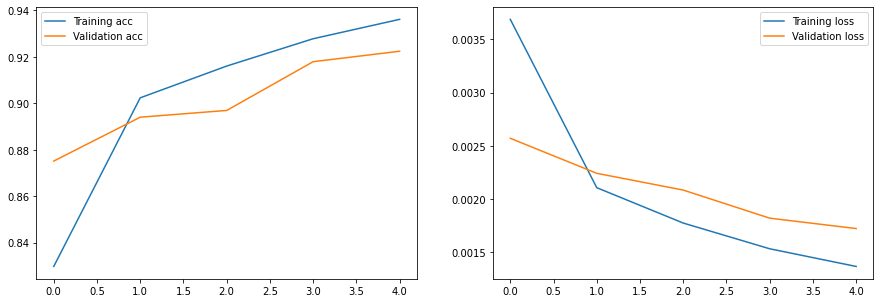

In [21]:
plot_results(hist)

In [22]:
#!wget https://raw.githubusercontent.com/xbresson/CE7454_2019/master/codes/labs_lecture06/lab01_mnist_multilayer/utils.py

In [23]:
import utils

Text(0.5, 1.0, 'label: 5')

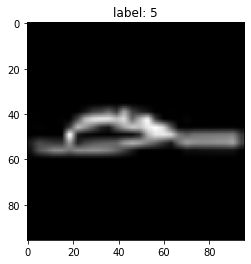

In [24]:
img, label = data_val[np.random.randint(8,21)]
plt.imshow(img.squeeze(), cmap = 'gray')
plt.title(f'label: {label}')

In [25]:
prob = net(img.unsqueeze(0).to('cuda'))
softmax = nn.Softmax()
prob = softmax(prob)
print(prob)

tensor([[6.5116e-04, 1.5444e-05, 1.3217e-04, 7.3836e-05, 9.9837e-06, 9.9778e-01,
         1.7929e-04, 6.5192e-04, 3.5895e-04, 1.4343e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


<ipython-input-25-7fb306ad7e93>:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob = softmax(prob)


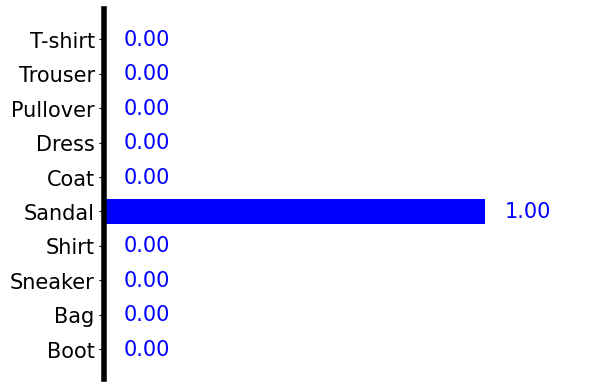

In [26]:
utils.show_prob_fashion_mnist(prob.to('cpu'))